# **Understanding the Difference Between Embedding Layers and Linear Layers**

- Embedding layers in PyTorch accomplish the same as linear layers that perform matrix multiplications; the reason we use embedding layers is computational efficiency
- We will take a look at this relationship step by step using code examples in PyTorch

In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.1


## Using nn.Embedding

In [2]:
# Suppose we have the following 3 training examples,
# which may represent token IDs in a LLM context
idx = torch.tensor([2, 3, 1])

# The number of rows in the embedding matrix can be determined
# by obtaining the largest token ID + 1.
# If the highest token ID is 3, then we want 4 rows, for the possible
# token IDs 0, 1, 2, 3
num_idx = max(idx)+1

# The desired embedding dimension is a hyperparameter
out_dim = 5

Let's implement a simple embedding layer:

In [ ]:
# We use the random seed for reproducibility since
# weights in the embedding layer are initialized with
# small random values
torch.manual_seed(123)

embedding = torch.nn.Embedding(num_idx, out_dim)

In [4]:
embedding.weight

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  1.5810],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015],
        [ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953]], requires_grad=True)

We can then use the embedding layers to obtain the vector representation of a training example with ID 1:

In [5]:
embedding(torch.tensor([1]))

tensor([[ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

What happens under the hood:
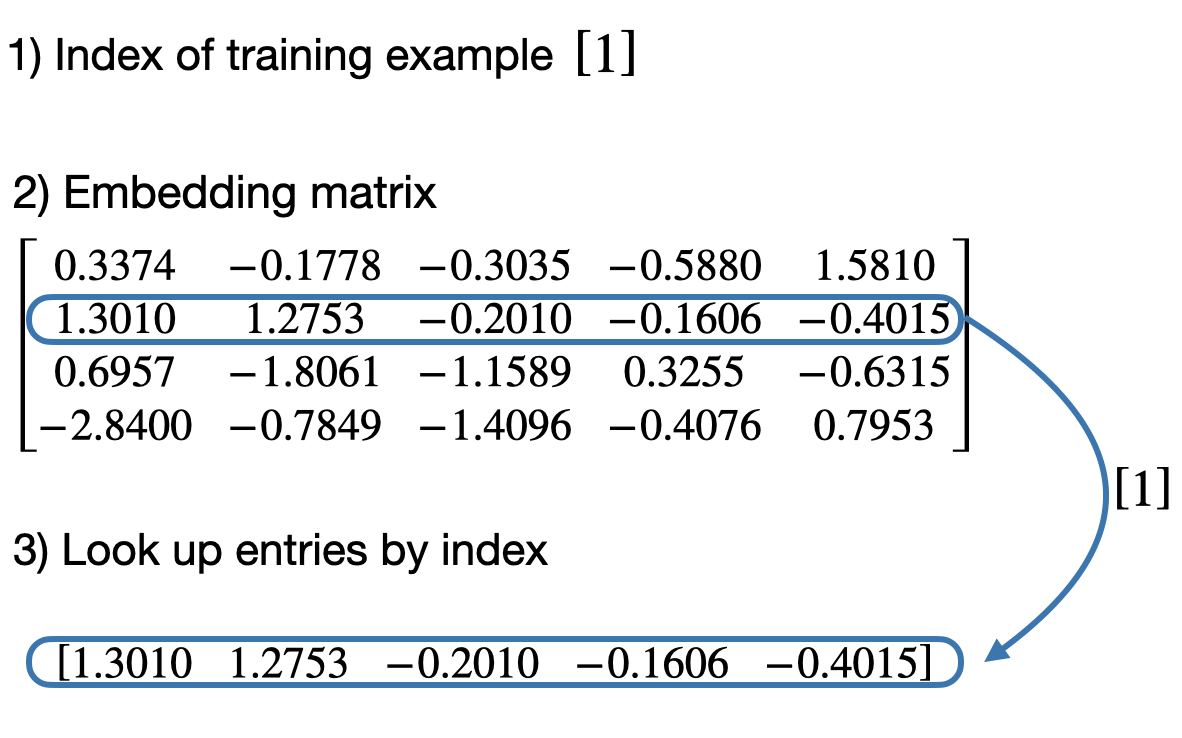

Similarly, we can use embedding layers to obtain the vector representation of a training example with ID 2:

In [6]:
embedding(torch.tensor([2]))

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315]],
       grad_fn=<EmbeddingBackward0>)

Now, let's convert all the training examples we have defined previously:

In [7]:
idx = torch.tensor([2, 3, 1])
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

What happens under the hood:
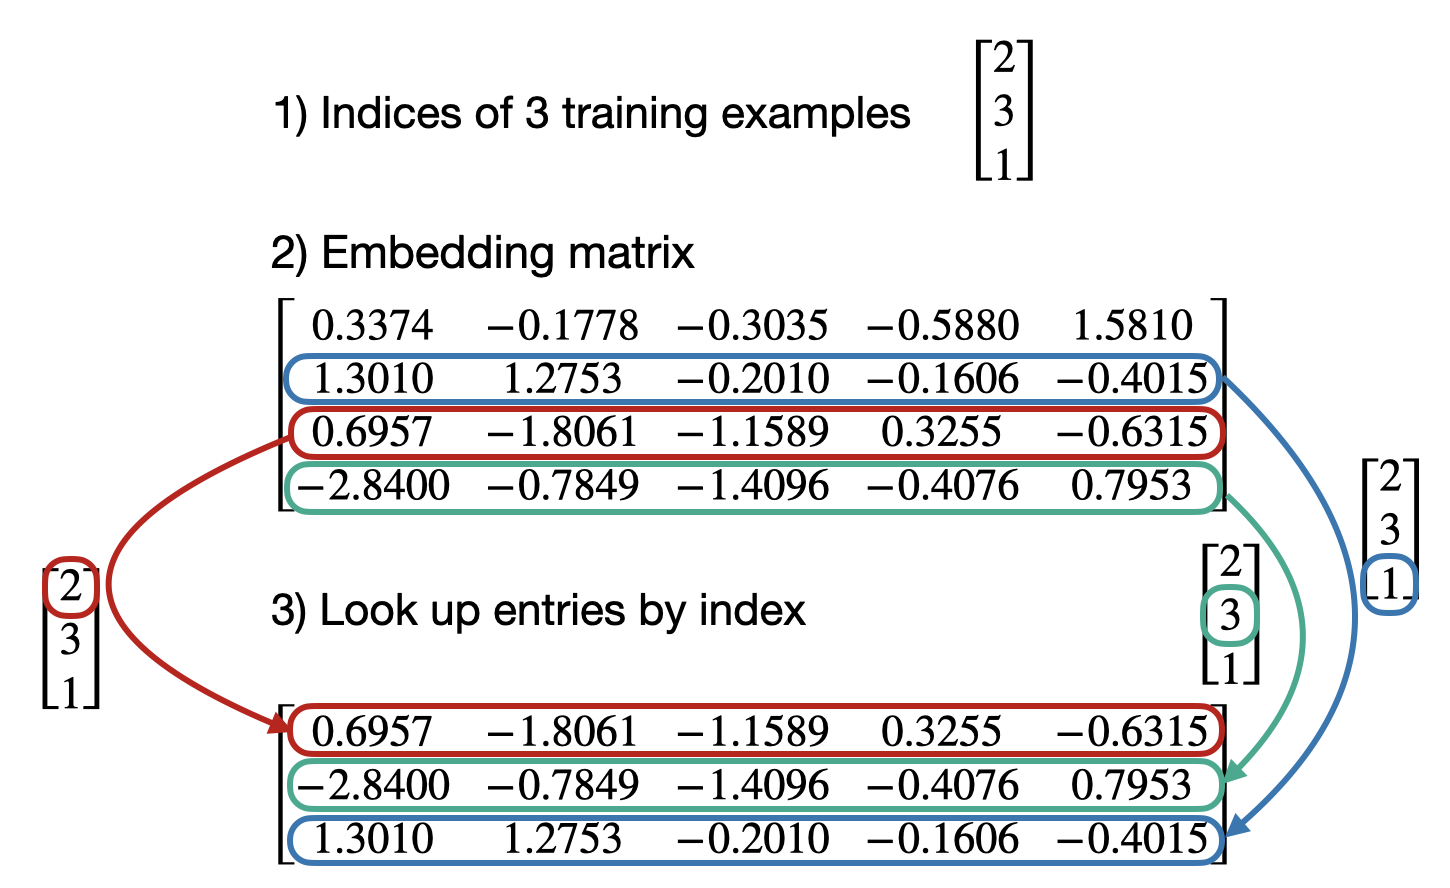

## Using nn.Linear

Now, we will demonstrate that the embedding layer above accomplishes exactly the same as nn.Linear layer on a one-hot encoded representation in PyTorch

First, let's convert the token IDs into a one-hot representation:

In [8]:
onehot = torch.nn.functional.one_hot(idx)
onehot

tensor([[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]])

Next, we initialize a Linear layer:

In [9]:
torch.manual_seed(123)
linear = torch.nn.Linear(num_idx, out_dim, bias=False)
linear.weight

Parameter containing:
tensor([[-0.2039,  0.0166, -0.2483,  0.1886],
        [-0.4260,  0.3665, -0.3634, -0.3975],
        [-0.3159,  0.2264, -0.1847,  0.1871],
        [-0.4244, -0.3034, -0.1836, -0.0983],
        [-0.3814,  0.3274, -0.1179,  0.1605]], requires_grad=True)

Note that the linear layer in PyTorch is also initialized with small random weights; to directly compare it to the Embedding layer above, we have to use the same small random weights, which is why we reassign them here:

In [10]:
linear.weight = torch.nn.Parameter(embedding.weight.T)

Now we can use the linear layer on the one-hot encoded representation of the inputs:

In [11]:
linear(onehot.float())

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]], grad_fn=<MmBackward0>)

As we can see, this is exactly the same as what we got when we used the embedding layer:

In [12]:
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

What happens under the hood for computing the first training example's token ID:
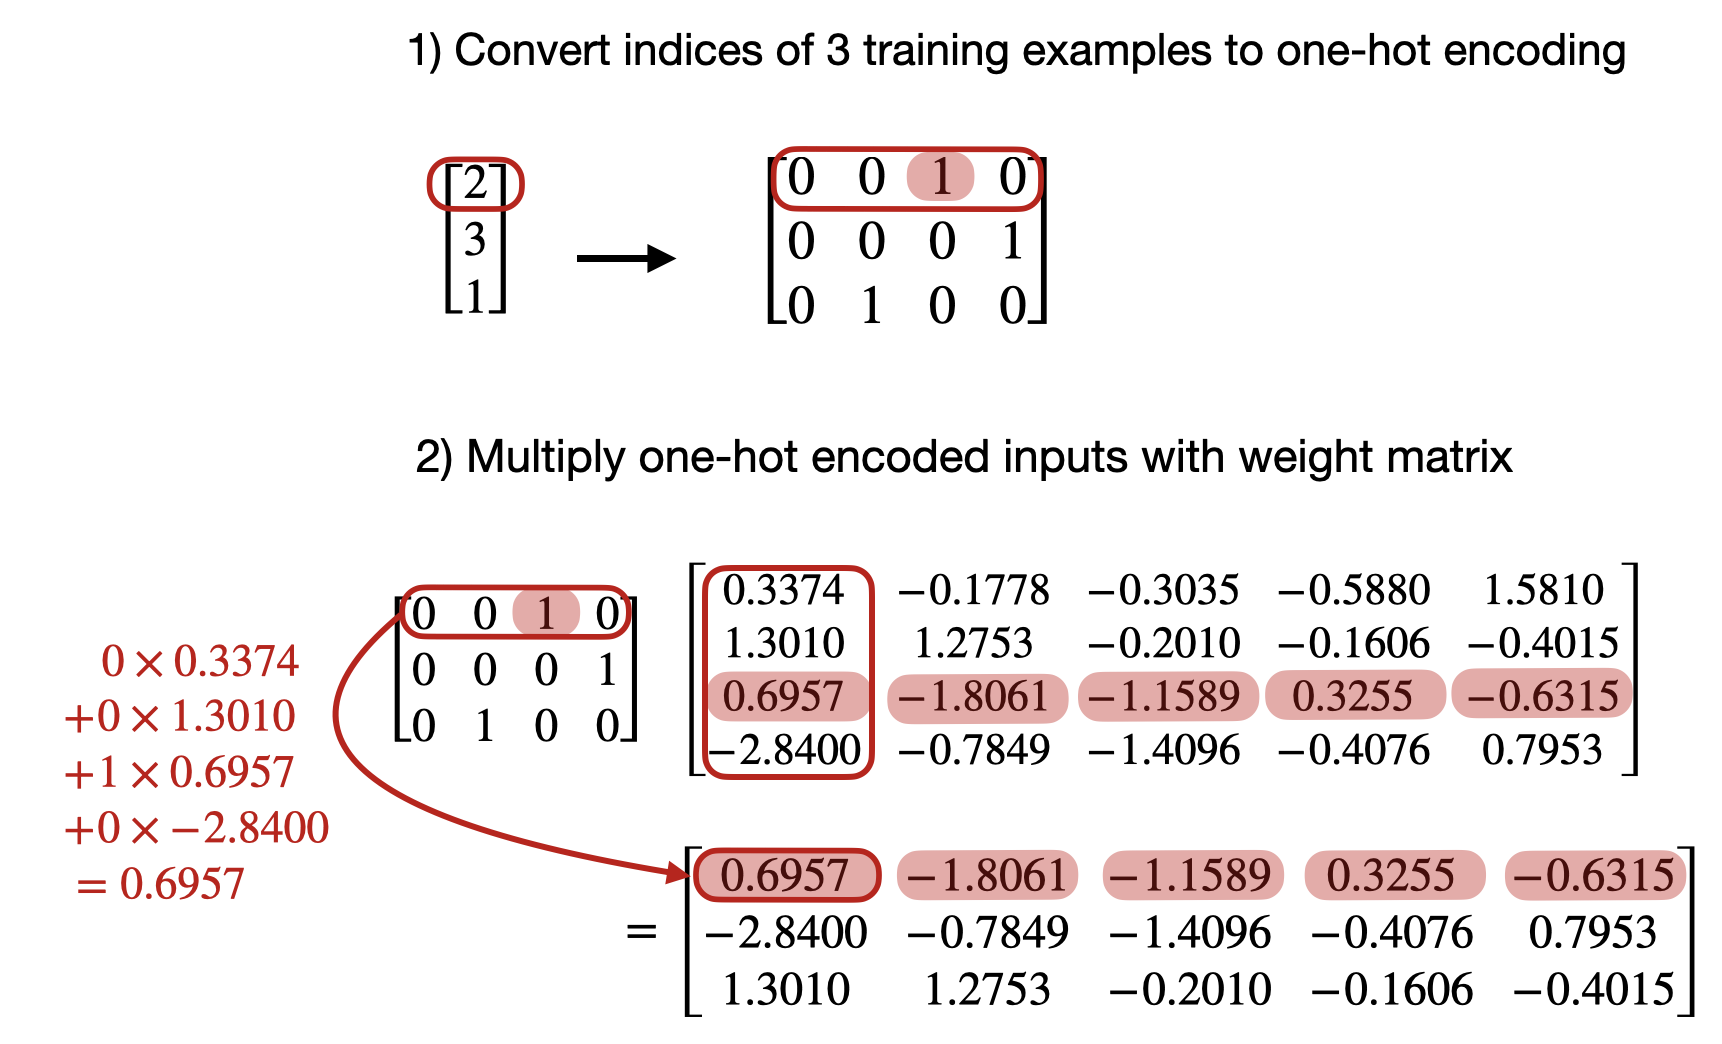

And for the second training example's token ID:
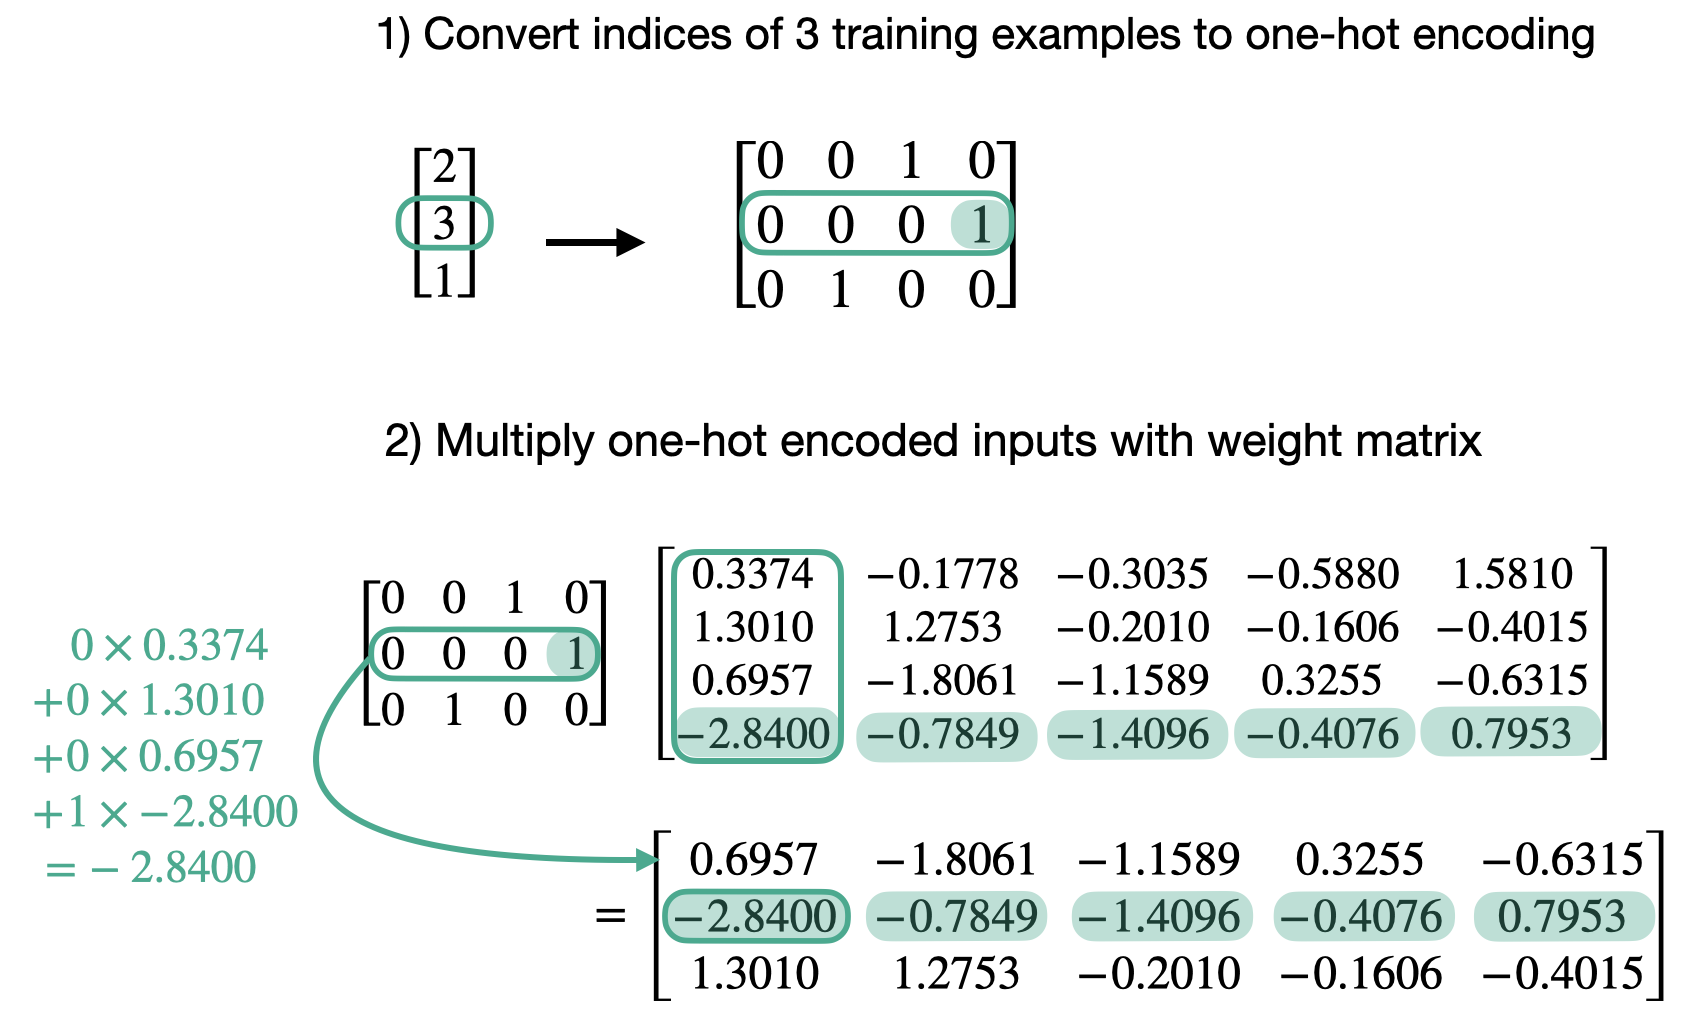

- Since all but one index in each one-hot encoded row are 0 (by design), this matrix multiplication is essentially the same as a look-up of the one-hot elements
- This use of the matrix multiplication on one-hot encodings is equivalent to the embedding layer look-up but can be inefficient if we work with large embedding matrices, because there are a lot of wasteful multiplications by zero